### Importing necessary libraries

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from bertopic import BERTopic
from urllib.parse import urlparse  

if os.path.abspath("..") not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))
from src.loader import NewsDataLoader
from src.utils import website_sentiment_distribution,extract_countries_from_article_content,find_popular_articles,remove_stopwords,keybert_keyword_extraction,calculate_similarity,perform_topic_modeling_with_mlflow



d:\School\10 Academy\Week 0\Code\news_correlation_10ac_week0\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mamam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mamam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\mamam\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data

### Loading Data

In [2]:
loader=NewsDataLoader()
ratingData = loader.load_data('../data/raw/data.csv/rating.csv')
trafficData = loader.load_data('../data/raw/traffic_data/traffic.csv')
locationData = loader.load_data('../data/raw/Domains_location.csv')

### Data Overview

#### 1. Rating Dataset

In [3]:
ratingData.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral


In [4]:
ratingData.shape

(58356, 13)

#### 2. Traffic Dataset

In [5]:
trafficData.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940
3,4,4,twitter.com,com,404985,1757127,twitter.com,com,4,4,404998,1753939
4,5,5,instagram.com,com,364746,1598085,instagram.com,com,5,5,364618,1594892


###

In [6]:
trafficData.shape

(1000000, 12)

#### 3. Domains location Dataset

In [7]:
locationData.head()

,SourceCommonName,location,Country
0,00221.info,SG,Senegal
1,01net.com,FR,France
2,01net.it,IT,Italy
3,0223.com.ar,AR,Argentina
4,022china.com,CH,China


In [8]:
locationData.shape

(37802, 3)

### Extract the Domain from the url in the rating dataset

In [9]:
ratingData['domain'] = ratingData['url'].apply(lambda x: urlparse(x).netloc)

In [10]:
ratingData.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,category,article,title_sentiment,domain
0,81664,NaN,Forbes,"Elizabeth Brownfield, Contributor, \n Elizabet...",superstar chef yannick alléno brings refined f...,Now open in Mayfair at Four Seasons Hotel Lond...,https://www.forbes.com/sites/elizabethbrownfie...,https://imageio.forbes.com/specials-images/ima...,2023-11-01 03:27:21.000000,"Pavyllon London, at Four Seasons Hotel London ...",Monaco,"pavyllon london, at four seasons hotel london ...",Neutral,www.forbes.com
1,81667,NaN,CNA,NaN,nice claim top spot in ligue 1 with late win a...,Nice moved into provisional first place in the...,https://www.channelnewsasia.com/sport/nice-cla...,https://onecms-res.cloudinary.com/image/upload...,2023-10-27 21:28:48.000000,Nice moved into provisional first place in the...,Monaco,nice moved into provisional first place in the...,Positive,www.channelnewsasia.com
2,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",Madagascar,"the world’s frogs, salamanders, newts and othe...",Negative,time.com
3,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,Madagascar,iron-rich sediment colors the red-orange water...,Neutral,phys.org
4,81703,NaN,Digital Trends,Jason Struss,everything leaving max (formerly hbo max) in n...,From Gangs of London to Fear the Walking Dead ...,https://www.digitaltrends.com/movies/everythin...,https://www.digitaltrends.com/wp-content/uploa...,2023-10-23 23:09:18.000000,"Everything ends. No, I’m not having an existen...",Madagascar,"everything ends. no, i’m not having an existen...",Neutral,www.digitaltrends.com


In [11]:
ratingdata_domains = ratingData['domain'].unique()
print(ratingdata_domains) 

['www.forbes.com' 'www.channelnewsasia.com' 'time.com' 'phys.org'
 'www.digitaltrends.com' 'www.aljazeera.com' 'www.bbc.co.uk'
 'deadline.com' 'www.euronews.com' 'www.rt.com' 'punchng.com'
 'www.ibtimes.com' 'indianexpress.com' 'www.etfdailynews.com'
 'abcnews.go.com' 'www.globalsecurity.org' 'www.marketscreener.com'
 'timesofindia.indiatimes.com' 'www.globenewswire.com'
 'economictimes.indiatimes.com' 'cnalifestyle.channelnewsasia.com'
 'www.cnn.com' 'www.businessinsider.com' 'gizmodo.com' 'www.wired.com'
 'www.theverge.com' 'www.npr.org' 'boingboing.net'
 'www.androidcentral.com' 'readwrite.com' 'www.bbc.com'
 'cnaluxury.channelnewsasia.com' 'allafrica.com']


### merge  the traffic dataset and the location dataset

In [12]:

traffic_location_df = pd.merge(trafficData, locationData, left_on='Domain', right_on='SourceCommonName', how='inner')
traffic_location_df.head()

,GlobalRank,TldRank,Domain,TLD,RefSubNets,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,SourceCommonName,location,Country
0,1,1,google.com,com,471274,2151358,google.com,com,1,1,471248,2147402,google.com,US,United States
1,2,2,facebook.com,com,465424,2250631,facebook.com,com,2,2,465297,2247135,facebook.com,VM,Vietnam
2,3,3,youtube.com,com,420579,1852995,youtube.com,com,3,3,420483,1848940,youtube.com,US,United States
3,7,7,apple.com,com,263655,804726,apple.com,com,7,7,263416,801213,apple.com,US,United States
4,8,8,microsoft.com,com,260546,739096,microsoft.com,com,8,8,260326,736093,microsoft.com,US,United States


### merge the traffic_location merged dataset with the rating dataset

In [13]:
merged_df=pd.merge(ratingData,traffic_location_df,left_on='domain',right_on='Domain',how='inner')
merged_df.head()

,article_id,source_id,source_name,author,title,description,url,url_to_image,published_at,content,...,RefIPs,IDN_Domain,IDN_TLD,PrevGlobalRank,PrevTldRank,PrevRefSubNets,PrevRefIPs,SourceCommonName,location,Country
0,81694,time,Time,Christina Larson / AP,amphibians are the world’s most vulnerable spe...,"The world’s frogs, salamanders, newts, and oth...",https://time.com/6320467/amphibians-most-vulne...,https://api.time.com/wp-content/uploads/2023/1...,2023-10-04 17:36:18.000000,"The worlds frogs, salamanders, newts and other...",...,133712,time.com,com,135,91,57983,133000,time.com,US,United States
1,81695,NaN,Phys.Org,Sara Schmidt,image: rusty red waters in madagascar,Iron-rich sediment colors the red-orange water...,https://phys.org/news/2023-10-image-rusty-red-...,https://scx2.b-cdn.net/gfx/news/2023/image-rus...,2023-10-31 18:04:02.000000,Iron-rich sediment colors the red-orange water...,...,49640,phys.org,org,622,81,25158,49348,phys.org,US,United States
2,81719,NaN,Phys.Org,Carlyn Chatfield,researcher scans tropical forest with mixed-re...,Rice University scientists used a commercially...,https://phys.org/news/2023-10-scans-tropical-f...,https://scx2.b-cdn.net/gfx/news/2023/rice-rese...,2023-10-19 20:02:03.000000,Rice University scientists used a commercially...,...,49640,phys.org,org,622,81,25158,49348,phys.org,US,United States
3,81723,NaN,Deadline,Patrick Hipes,"‘taylor swift: the eras tour’ movie: tickets, ...",Taylor Swift has the highest-grossing concert ...,https://deadline.com/feature/taylor-swift-eras...,https://deadline.com/wp-content/uploads/2023/1...,2023-10-11 14:30:00.000000,Taylor Swift has the highest-grossing concert ...,...,43299,deadline.com,com,962,549,19347,43044,deadline.com,US,United States
4,81731,NaN,Phys.Org,"Louw Claassens, David Harasti, Graham Short",tiny and mysterious: research sheds light on s...,Seahorses are considered fabled creatures by m...,https://phys.org/news/2023-10-tiny-mysterious-...,https://scx2.b-cdn.net/gfx/news/hires/2021/sea...,2023-10-25 16:52:04.000000,Seahorses are considered fabled creatures by m...,...,49640,phys.org,org,622,81,25158,49348,phys.org,US,United States


## Exploratory Data Analysis (EDA)

### 1. Websites that have the largest count of news articles

In [14]:
# Count the number of articles per website
website_counts = ratingData['domain'].value_counts().reset_index()
website_counts.columns = ['domain', 'count']
print(website_counts[:10])


                         domain  count
0          www.etfdailynews.com  16746
1         www.globenewswire.com   5423
2  economictimes.indiatimes.com   5310
3        www.globalsecurity.org   3119
4                www.forbes.com   2784
5   timesofindia.indiatimes.com   2194
6                abcnews.go.com   2058
7       www.businessinsider.com   2034
8                 www.bbc.co.uk   2032
9                   punchng.com   1800


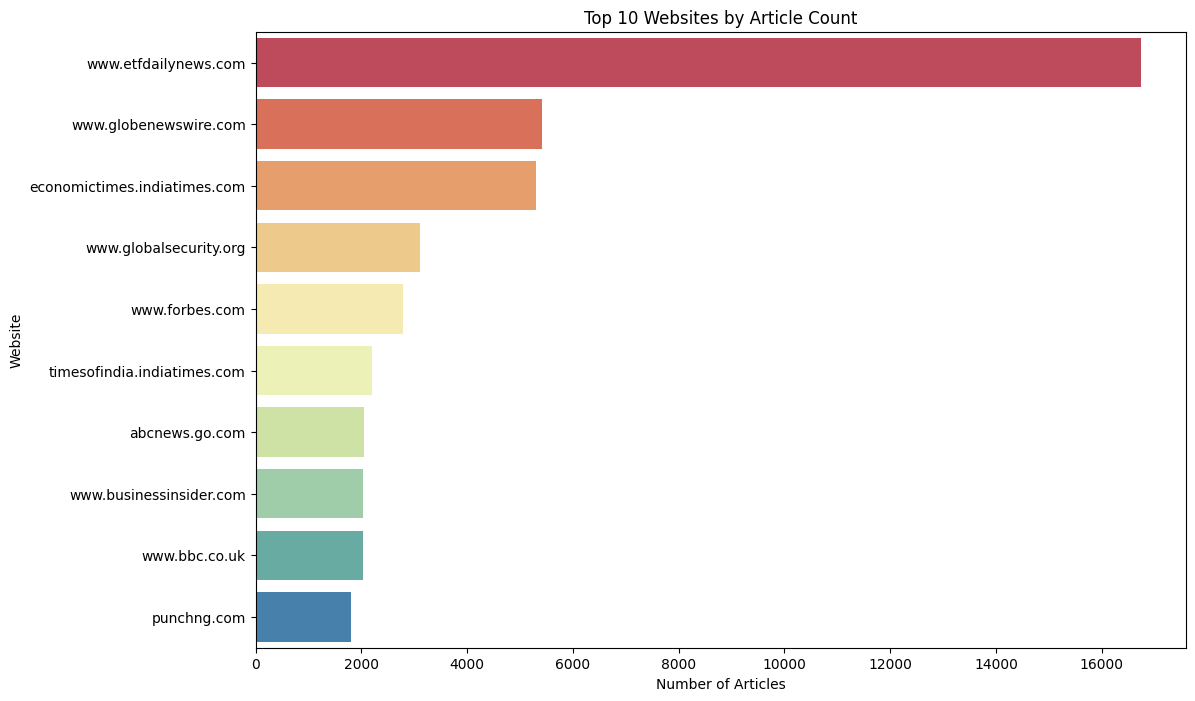

In [15]:
# Plot the top 10 websites by article count
plt.figure(figsize=(12, 8))
sns.barplot(data=website_counts.head(10), x='count', y='domain', hue='domain', palette='Spectral', legend=False)
plt.title('Top 10 Websites by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Website')
plt.show()

In [16]:
# Count the number of articles per website
website_counts = ratingData['domain'].value_counts().reset_index()
website_counts.columns = ['domain', 'count']
sorted_website_counts = website_counts.sort_values('count')

bottom_10_websites = sorted_website_counts.head(10)
print(bottom_10_websites)

                              domain  count
32     cnaluxury.channelnewsasia.com      4
31  cnalifestyle.channelnewsasia.com     18
30                     allafrica.com     20
29                       www.bbc.com     81
28                  www.theverge.com    214
27                       www.cnn.com    267
26                     www.wired.com    270
25                  www.euronews.com    286
24                     readwrite.com    324
23                       gizmodo.com    388


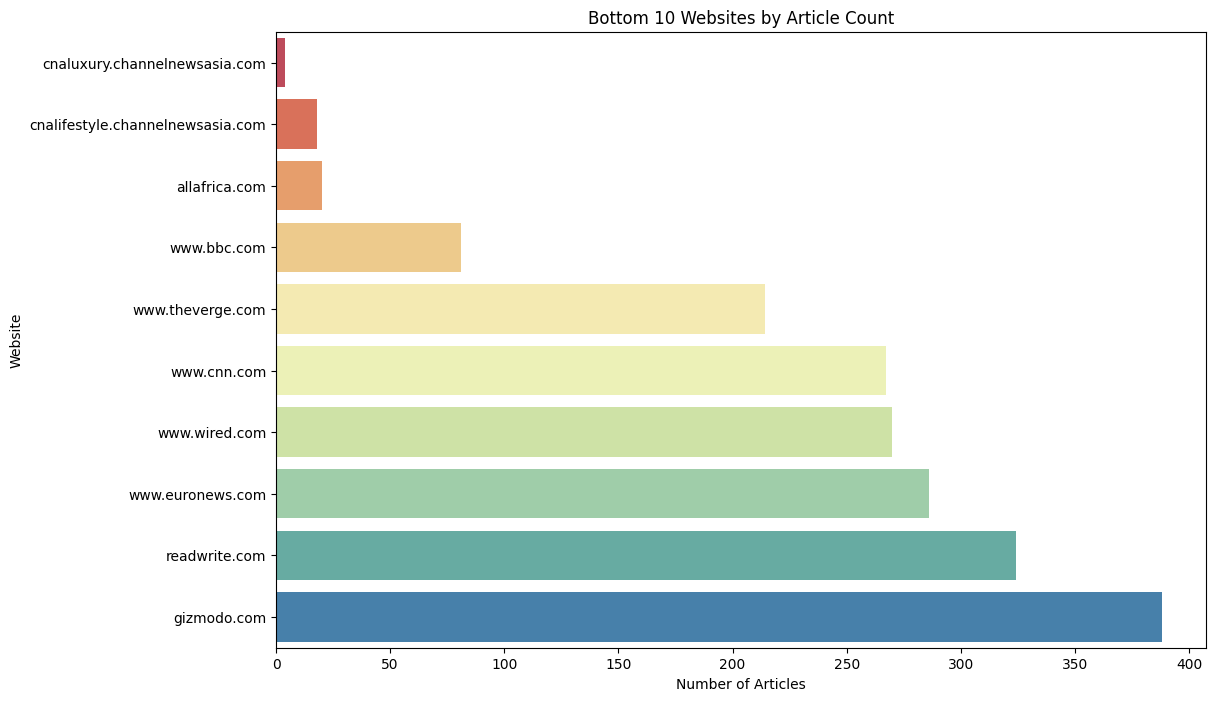

In [17]:
# Plot the top 10 websites by article count
plt.figure(figsize=(12, 8))
sns.barplot(data=bottom_10_websites.head(10), x='count', y='domain', palette='Spectral', dodge=False)
plt.title('Bottom 10 Websites by Article Count')
plt.xlabel('Number of Articles')
plt.ylabel('Website')
plt.show()

### 2. Websites with the highest numbers of visitors traffic 


In [18]:
top_traffic_websites = trafficData.sort_values('GlobalRank').head(10)
print(top_traffic_websites['Domain'])

0              google.com
1            facebook.com
2             youtube.com
3             twitter.com
4           instagram.com
5            linkedin.com
6               apple.com
7           microsoft.com
8    googletagmanager.com
9           wikipedia.org
Name: Domain, dtype: object


In [19]:
top_traffic_websites = trafficData.sort_values('GlobalRank').tail(10).reset_index(drop=True)
print(top_traffic_websites['Domain'])

0              eiretrip.com
1      exploring-africa.com
2                  hmag.com
3            irishcycle.com
4           keith-baker.com
5                kireie.com
6               mt-lock.com
7             pinkwater.com
8            soderhomes.com
9    toyotamusicfactory.com
Name: Domain, dtype: object


### 3. Countries with the highest number of news media 

In [20]:
# Count the number of Country per domain
country_counts = traffic_location_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'domain']
top_10_Countries=country_counts[:10]
print(top_10_Countries)


          Country  domain
0   United States   10343
1  United Kingdom    1505
2           Italy     868
3         Germany     712
4          France     691
5          Russia     668
6          Canada     540
7           China     483
8       Australia     481
9           India     411


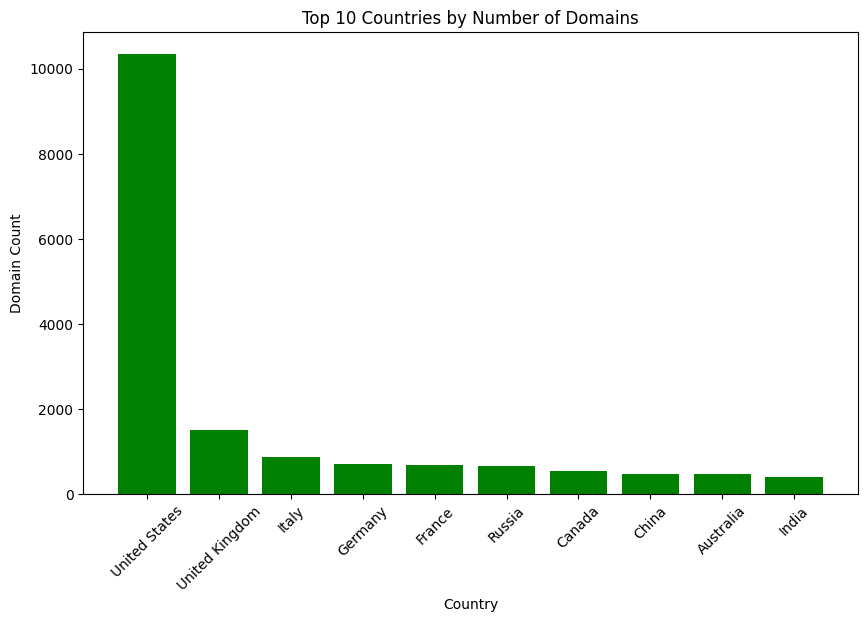

In [21]:
# Plotting the top 10 countries by domain count
plt.figure(figsize=(10, 6))
plt.bar(top_10_Countries['Country'], top_10_Countries['domain'], color='green')
plt.xlabel('Country')
plt.ylabel('Domain Count')
plt.title('Top 10 Countries by Number of Domains')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Count the number of Country per domain
country_counts = traffic_location_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'domain']
bottom_10_Countries=country_counts.tail(10).reset_index(drop=True)
print(bottom_10_Countries)

                                        Country  domain
0                                          Laos       1
1                                  Cook Islands       1
2                                   Isle of Man       1
3                              Pitcairn Islands       1
4                                       Burundi       1
5              Saint Vincent and the Grenadines       1
6                                       Grenada       1
7                                        Monaco       1
8  South Georgia and the South Sandwich Islands       1
9                                      Anguilla       1


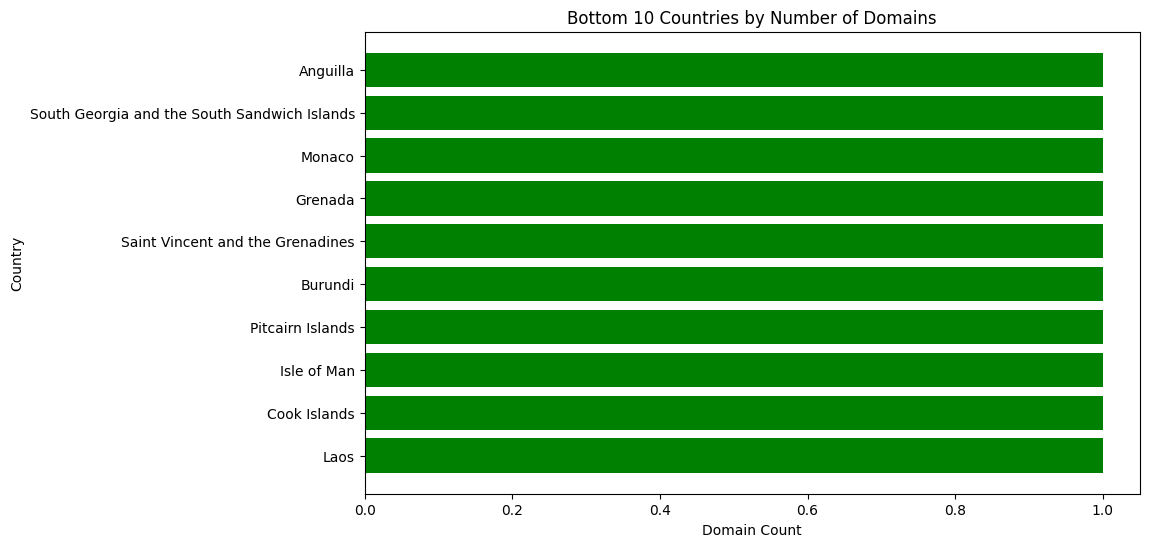

In [23]:
# Plotting the top 10 countries by domain count
plt.figure(figsize=(10, 6))
plt.barh(bottom_10_Countries['Country'], bottom_10_Countries['domain'], color='green')
plt.ylabel('Country')
plt.xlabel('Domain Count')
plt.title('Bottom 10 Countries by Number of Domains')
plt.show()

### Countries that have many articles written about them - the content of the news is about that country

In [24]:

popular_countries = find_popular_articles(ratingData)
print(popular_countries)

Counter({('China', 'NNP'): 8, ('Indian', 'JJ'): 8, ('Maldives', 'NNP'): 6, ('Israel', 'NNP'): 5, ('India', 'NNP'): 5, ('African', 'JJ'): 4, ('Maldives', 'NNS'): 3, ('Brazilian', 'JJ'): 2, ('Russian', 'JJ'): 2, ('Madagascar', 'NNP'): 1, ('French', 'JJ'): 1, ('Cimade', 'NNP'): 1, ('Fisheries', 'NNP'): 1, ('Oceanography', 'NNP'): 1, ('Japan', 'NNP'): 1, ('Nigerian', 'JJ'): 1, ('Kigali', 'NNP'): 1, ('Port', 'NNP'): 1, ('Gaetan', 'NNP'): 1, ('South', 'NNP'): 1, ('Matcha', 'NNP'): 1, ('Japanese', 'JJ'): 1, ('Palestinian', 'JJ'): 1, ('German', 'JJ'): 1, ('Malawi', 'NNP'): 1, ('Africa', 'NNP'): 1, ('Vancouver', 'NNP'): 1, ('British', 'NNP'): 1, ('WASHINGTON', 'NN'): 1, ('West', 'JJ'): 1, ('Paroedura', 'NNP'): 1, ('Nigeria', 'NNP'): 1, ('Navratri', 'NNP'): 1, ('Dublin', 'NNP'): 1, ('Type', 'NNP'): 1, ('Demand', 'NNP'): 1, ('Egypt', 'NNP'): 1, ('Jordan', 'NNP'): 1, ('African', 'NNP'): 1, ('Togolese', 'JJ'): 1, ('Maldives.Ananya', 'NNP'): 1, ('Malé', 'NNP'): 1, ('Thai', 'NNP'): 1, ('Nitaraappears

### Websites with the highest count of positive, neutral, and negative sentiment


In [25]:

# Ensure sentiment column is categorical and defined
ratingData['title_sentiment'] = ratingData['title_sentiment'].astype('category')

# Get sentiment distribution with mean and median
sentiment_distribution = website_sentiment_distribution(ratingData)
sentiment_distribution.head()

title_sentiment,Negative,Neutral,Positive,Total,Mean,Median
source_name,,,,,,
ABC News,726,1193,139,2058,686.000000,726.0
Al Jazeera English,706,927,31,1664,554.666667,706.0
AllAfrica - Top Africa News,8,12,0,20,6.666667,8.0
Android Central,38,212,272,522,174.000000,212.0
BBC News,854,1185,74,2113,704.333333,854.0


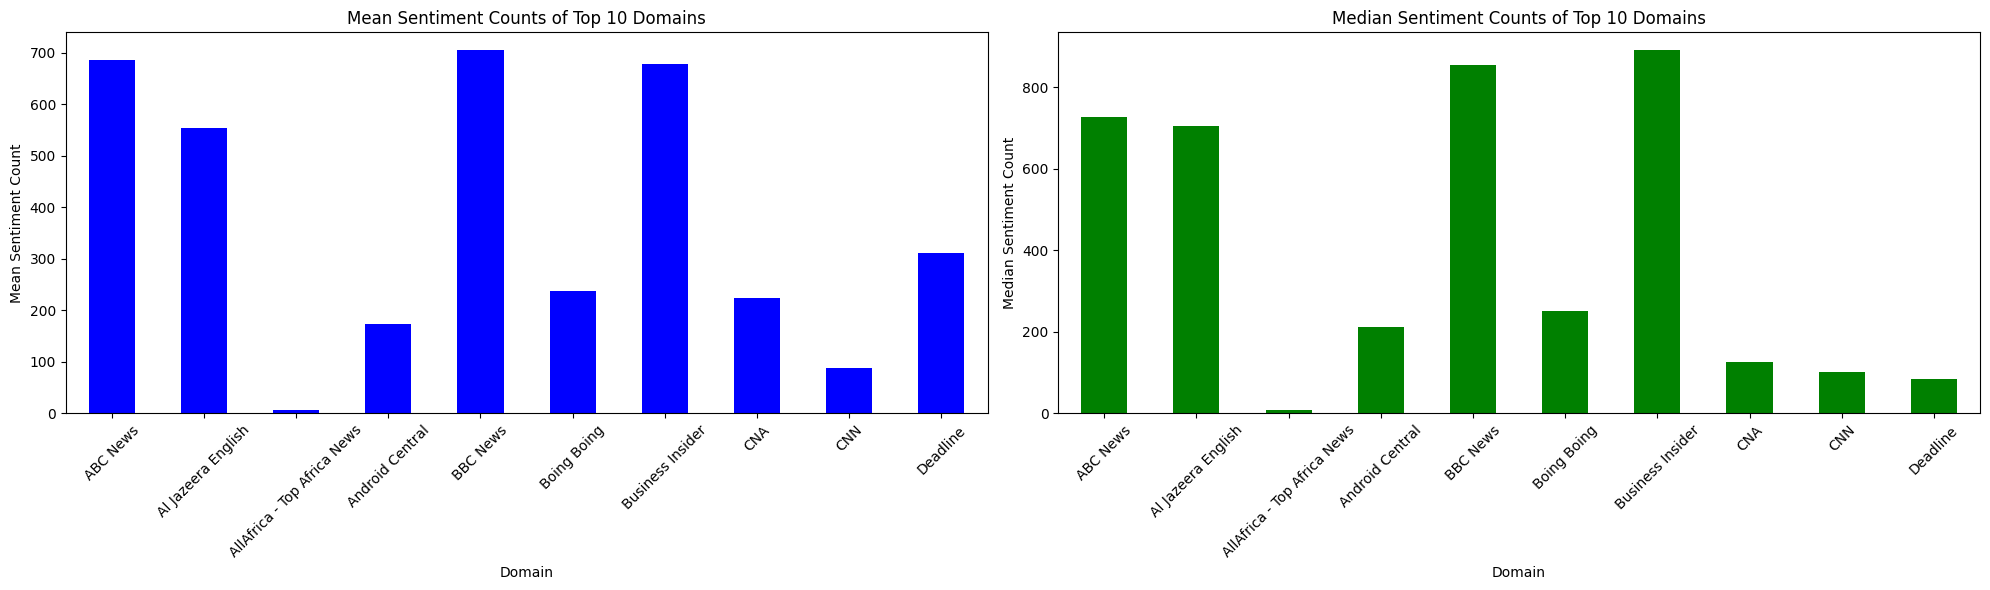

In [26]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Plot the mean sentiment counts
sentiment_distribution[['Mean']].head(10).plot(kind='bar', ax=ax[0], color='blue', legend=False)
ax[0].set_title('Mean Sentiment Counts of Top 10 Domains')
ax[0].set_xlabel('Domain')
ax[0].set_ylabel('Mean Sentiment Count')
ax[0].tick_params(axis='x', rotation=45)

# Plot the median sentiment counts
sentiment_distribution[['Median']].head(10).plot(kind='bar', ax=ax[1], color='green', legend=False)
ax[1].set_title('Median Sentiment Counts of Top 10 Domains')
ax[1].set_xlabel('Domain')
ax[1].set_ylabel('Median Sentiment Count')
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

### check the distribution of sentiments for a particular domain

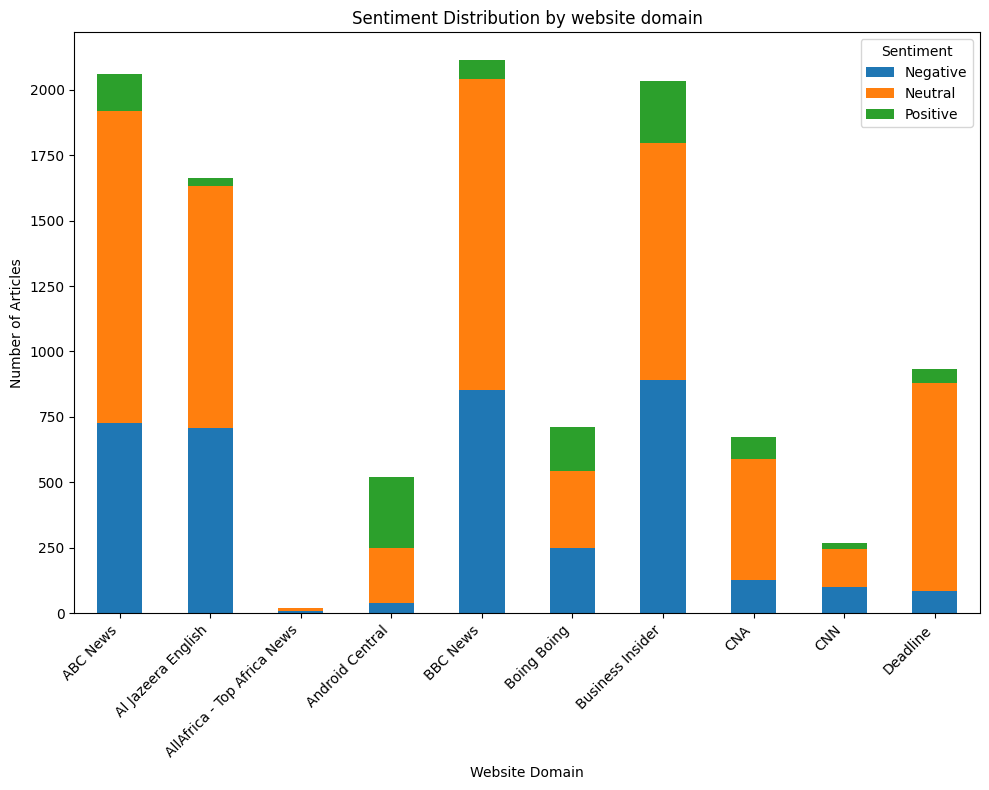

In [27]:
sentiment_counts = ratingData.groupby(['source_name','title_sentiment']).size().unstack(fill_value = 0)
sentiment_counts.head(10).plot(kind='bar',stacked=True,figsize=(10,8))

plt.title('Sentiment Distribution by website domain')
plt.xlabel('Website Domain')
plt.ylabel('Number of Articles')

plt.xticks(rotation=45,ha='right')
plt.legend(title='Sentiment')

plt.tight_layout()
plt.show()

## Task 2

### Keybert keyword Extraction

In [28]:

# Extract keywords from specified fields
title_keywords_list, content_keywords_list = keybert_keyword_extraction(ratingData.head(100))

print(f'title ={title_keywords_list}')
print(f'content ={content_keywords_list}')

title =[[('cuisine', 0.4604), ('alléno', 0.4443), ('yannick', 0.4361), ('chef', 0.4345), ('pavyllon', 0.3906)], [('clermont', 0.5702), ('ligue', 0.553), ('claim', 0.3589), ('spot', 0.2999), ('nice', 0.1805)], [('amphibians', 0.6709), ('species', 0.4783), ('threats', 0.3642), ('vulnerable', 0.3247), ('world', 0.1969)], [('madagascar', 0.5414), ('waters', 0.496), ('rusty', 0.4761), ('red', 0.4086), ('image', 0.2435)], [('hbo', 0.5099), ('max', 0.4485), ('2023', 0.3869), ('november', 0.3107), ('leaving', 0.2381)], [('hamas', 0.5025), ('humanitarian', 0.4592), ('truce', 0.4439), ('israel', 0.4144), ('unga', 0.3389)], [('malawi', 0.4326), ('temperatures', 0.3693), ('soar', 0.3663), ('heatwave', 0.3551), ('warning', 0.2828)], [('tropical', 0.4489), ('forest', 0.4308), ('scans', 0.321), ('researcher', 0.2187), ('device', 0.2047)], [('swift', 0.5023), ('tour', 0.41), ('taylor', 0.3601), ('tickets', 0.3503), ('movie', 0.3248)], [('defamation', 0.3674), ('pen', 0.2937), ('french', 0.2666), ('mig

### How Similar are keywords in the headline(title) compared to keywords in the news body (Content) using cosine similarity

In [29]:

# Calculate similarity
similarity_list = calculate_similarity(title_keywords_list, content_keywords_list)

print("Similarity List for the first 10 Rows:", similarity_list)


Similarity List for the first 10 Rows: [0.38399253230719543, 0.6393209432735083, 0.36409896945924114, 0.41353606562757667, 0.22317891649249405, 0.8086671091751745, 0.3717188085255175, 0.27416030360004423, 0.37578613396274174, 0.525511106098153, 0.3894837208781152, 0.20017654735812038, 0.0, 0.6623772189850381, 0.0, 0.7645345176360333, 0.4057741419993619, 0.8461663033259257, 0.4684153677466457, 0.30220379113524437, 0.08056778624290854, 0.1871258796974107, 0.6783691365041632, 0.3682557641423591, 0.22164735666535962, 0.704933689315638, 0.21479001973999876, 0.3510874247383153, 0.37695124072879066, 0.8839919536669418, 0.4019893539664881, 0.21704980341104774, 0.0, 0.0, 0.80415049474751, 0.6506352636605983, 0.5771237890322756, 0.0, 0.35766459732950656, 0.9079903648408307, 0.6710040634224187, 0.7047119562502664, 0.5297401673966426, 0.27314241656455307, 0.605961124474258, 0.19994742391259673, 0.6385332253078223, 0.7565513118703324, 0.0, 0.29546486594513166, 0.44051694348393694, 0.877632952408185

## Perform topic modelling using bertopic



In [30]:

sampled_data = ratingData.sample(1000)
#sampled_data=ratingData
sampled_data['text'] = sampled_data['title'] + ' ' + sampled_data['content']
sampled_list = sampled_data['text'].tolist()

sampled_list = [remove_stopwords(text) for text in sampled_list]

topic_model = BERTopic()
topics,probs = topic_model.fit_transform(sampled_list)
print('Model fitting Done!')
topic_model.get_topic_info()

Model fitting Done!


,Topic,Count,Name,Representation,Representative_Docs
0,-1,253,-1_chars_new_2023_us,"[chars, new, 2023, us, said, house, home, form...",[could us house speaker kevin mccarthy lose jo...
1,0,173,0_inc_quarter_shares_recent,"[inc, quarter, shares, recent, llc, according,...",[carnegie capital asset management llc lowers ...
2,1,81,1_gaza_israeli_israel_palestinian,"[gaza, israeli, israel, palestinian, chars, wa...",[Israeli forces raid Gaza's largest hospital s...
3,2,53,2_china_climate_chars_global,"[china, climate, chars, global, chinese, xi, a...",[China's Xi courting Indo-Pacific leaders flur...
4,3,49,3_film_chars_films_movie,"[film, chars, films, movie, abu, dhabi, game, ...",[‘the boys’ director chung ji-young: “for peop...
5,4,49,4_ai_ceo_chars_microsoft,"[ai, ceo, chars, microsoft, getty, impact, inn...",[Sam Altman: extraordinary firing AI superstar...
6,5,43,5_market_billion_usd_global,"[market, billion, usd, global, globe, newswire...",[Atherectomy Systems Market Hit USD 1.1 billio...
7,6,38,6_india_rs_crore_gold,"[india, rs, crore, gold, sales, trade, chars, ...",[India may need cheaper crude gold clear Diwal...
8,7,33,7_earnings_results_eps_2023,"[earnings, results, eps, 2023, guidance, conse...",[Cinemark (NYSE:CNK) Releases Earnings Results...
9,8,30,8_stocknewscom_rating_coverage_issued,"[stocknewscom, rating, coverage, issued, hold,...",[Orion Energy Systems (NASDAQ:OESX) Earns Hold...


### Testing the Model

In [31]:
first_row_content = ratingData.iloc[22]['content']  
processed_content = remove_stopwords(first_row_content)

# Transform the new content using the trained BERTopic model
topic, prob = topic_model.transform([processed_content])

# Display the results
print('The Content',ratingData.iloc[22]['content'] )
print("Predicted Topic:", topic[0])
print("Probability of the Topic:", prob[0])

The Content The conflict between Israel and Palestine began just under a century ago, but the significance of the land precedes even Biblical times. The area in question covers a tiny swathe of the Southern Leva… [+14960 chars]
Predicted Topic: 1
Probability of the Topic: 0.6522808853779458


### Performing  topic Modeling with MLFlow

In [32]:
topic_info, model = perform_topic_modeling_with_mlflow(ratingData)

Model fitting Done!


2024/08/28 22:04:23 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/08/28 22:04:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Logged to MLflow successfully!
